In [1]:
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

from keras.models import load_model
from keras.models import model_from_json

from PIL import Image
import numpy as np
from selenium import webdriver
import cv2
import time
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
from selenium.webdriver.chrome.options import Options

In [2]:
def mnist_make_model(image_w: int, image_h: int):
    # Neural network model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(image_w*image_h,)))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
    return model

In [3]:
model = mnist_make_model(10,10)

In [4]:
model.load_weights('model.h5')



print('Model successfully loaded')

Model successfully loaded


In [5]:
def crop(im):
    list_cap = []
    im = im.convert("P")
    im2 = Image.new("P",im.size,255)

    im = im.convert("P")

    temp = {}

    for x in range(im.size[1]):
        for y in range(im.size[0]):
            pix = im.getpixel((y,x))
            temp[pix] = pix
            if pix != 0: # these are the numbers to get
                im2.putpixel((y,x),0)
    

    inletter = False
    foundletter=False
    start = 0
    end = 0
    count = 0
    letters = []
    for y in range(im2.size[0]): # slice across
        for x in range(im2.size[1]): # slice down
            pix = im2.getpixel((y,x))
            if pix != 255:
                inletter = True
        if foundletter == False and inletter == True:
            foundletter = True
            start = y

        if foundletter == True and inletter == False:
            foundletter = False
            end = y
            letters.append((start,end))

        inletter=False

    for letter in letters:
        im3 = im2.crop(( letter[0] , 0, letter[1],im2.size[1] ))
        im3 = im3.transpose(Image.ROTATE_90)

        letters1 = []

        for y in range(im3.size[0]): # slice across
            for x in range(im3.size[1]): # slice down
                pix = im3.getpixel((y,x))
                if pix != 255:
                    inletter = True
            if foundletter == False and inletter == True:
                foundletter = True
                start = y

            if foundletter == True and inletter == False:
                foundletter = False
                end = y
                letters1.append((start,end))

            inletter=False

        for letter in letters1:
            im4 = im3.crop(( letter[0] , 0, letter[1],im3.size[1] ))
        im4 = im4.transpose(Image.ROTATE_270)
        resized_img = im4.resize((10, 10), Image.ANTIALIAS)
        img_arr = np.array(resized_img)/255
        img_arr = img_arr.reshape((1, 10*10))
        list_cap.append(model.predict_classes([img_arr])[0])
    return ''.join([str(elem) for elem in list_cap])

In [6]:
def get_captcha(driver):
    with open('snt.png', 'wb') as file:
        file.write(driver.find_element_by_xpath('//*[@id="captchaImg"]').screenshot_as_png)
    im2 = Image.open('/Users/aleksejkudrasov/Downloads/solving_captchas_code_examples/snt.png')
    return im2

In [7]:
# chrome_options = Options()
# chrome_options.add_argument("--headless")
driver = webdriver.Chrome('/Users/aleksejkudrasov/Downloads/chromedriver')

In [8]:
df_table = []
driver.get('http://www.vybory.izbirkom.ru')
driver.find_element_by_xpath('/html/body/table[2]/tbody/tr[2]/td/center/table/tbody/tr[2]/td/div/table/tbody/tr[3]/td[3]').click()
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
list_a = soup.find_all('table')[1].find_all('a')
for a in list_a:
    name = a.text
    link = a['href']
    df_table.append([name,link])
df_table = pd.DataFrame(df_table, columns = ['name','link'])

In [ ]:
for index, line in merge.iterrows():
    if line['link_x'] == 'None':
        driver.get(line['link_y'])
        time.sleep(0.6)
        captcha = crop(get_captcha(driver))
        driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
        driver.find_element_by_xpath('//*[@id="send"]').click()
        time.sleep(0.6)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')          
        for i in range(len(soup.find_all('tr'))):
            if '\nРЕЗУЛЬТАТЫ ВЫБОРОВ\n' == soup.find_all('tr')[i].text:
                rez_link = soup.find_all('tr')[i+1].find('a')['href']
        driver.get(rez_link)
        time.sleep(0.6)
        captcha = crop(get_captcha(driver))
        driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
        driver.find_element_by_xpath('//*[@id="send"]').click()
        time.sleep(0.6)
        table_result = []
        tbody = soup.find_all('tbody')
        list_tr = tbody[1].find_all('tr')
        ful_name = list_tr[0].text
        table_result = []
        for table in list_tr[3].find_all('table'):
            if len(table.find_all('tr'))>5:
                for tr in table.find_all('tr'):
                    snt_tr = []
                    for td in tr.find_all('td'):
                        snt_tr.append(td.text.strip())
                    table_result.append(snt_tr)
        head_name = line['name']
        child_name = ''
        result_table.append([line['name'],line['link_y'],rez_link,head_name,child_name,ful_name,pd.DataFrame(line, columns = ['index', 'name','count'])])
    else:
        driver.get(line['link_x'])
        time.sleep(1)
        captcha = crop(get_captcha(driver))
        driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
        driver.find_element_by_xpath('//*[@id="send"]').click()
        time.sleep(1)
        try:
            driver.find_element_by_xpath('/html/body/table[2]/tbody/tr[2]/td/form/select')
            options = [x for x in driver.find_elements_by_tag_name("option")]
            for element in options:
                if '-' in element.get_attribute("value"):
                    continue
                else:
                    head_name = element.text
                    driver.get(element.get_attribute("value"))
                    time.sleep(1)
                    captcha = crop(get_captcha(driver))
                    driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
                    driver.find_element_by_xpath('//*[@id="send"]').click()
                    time.sleep(1)
                    html = driver.page_source
                    soup = BeautifulSoup(html, 'html.parser')          
                    for i in range(len(soup.find_all('tr'))):
                        if '\nРЕЗУЛЬТАТЫ ВЫБОРОВ\n' == soup.find_all('tr')[i].text:
                            rez_link = soup.find_all('tr')[i+1].find('a')['href']
                    driver.get(rez_link)
                    captcha = crop(get_captcha(driver))
                    driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
                    driver.find_element_by_xpath('//*[@id="send"]').click()
                    time.sleep(1)
                    table_result = []
                    tbody = soup.find_all('tbody')
                    list_tr = tbody[1].find_all('tr')
                    ful_name = list_tr[0].text
                    table_result = []
                    for table in list_tr[3].find_all('table'):
                        if len(table.find_all('tr'))>5:
                            for tr in table.find_all('tr'):
                                snt_tr = []
                                for td in tr.find_all('td'):
                                    snt_tr.append(td.text.strip())
                                table_result.append(snt_tr)
                    child_name = ''
                    merge.loc[index,'result_table'] = pd.DataFrame(table_result, columns = ['index','row_name','count'])
                    result_table.append([line['name'],line['link_y'],rez_link,head_name,child_name,ful_name,pd.DataFrame(line, columns = ['index', 'name','count'])])
                    driver.find_element_by_xpath('/html/body/table[2]/tbody/tr[2]/td/form/select')
                    options1 = [x for x in driver.find_elements_by_tag_name("option")]
                    list_link = []
                    for element1 in options1:
                        if '-' in element1.get_attribute("value"):
                            continue
                        else:
                            list_link.append([element1.text, element1.get_attribute("value")])
                    for element1 in list_link:
                        child_name = element1[0]
                        driver.get(element1[1])
                        time.sleep(1)
                        captcha = crop(get_captcha(driver))
                        driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
                        driver.find_element_by_xpath('//*[@id="send"]').click()
                        time.sleep(1)
                        try :
                            driver.find_element_by_xpath('//*[@id="captchaRes"]')
                            time.sleep(1)
                            captcha = crop(get_captcha(driver))
                            driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
                            driver.find_element_by_xpath('//*[@id="send"]').click()
                            time.sleep(1)
                        except:
                            html = driver.page_source
                            soup = BeautifulSoup(html, 'html.parser')          
                            for i in range(len(soup.find_all('tr'))):
                                if '\nРЕЗУЛЬТАТЫ ВЫБОРОВ\n' == soup.find_all('tr')[i].text:
                                    rez_link = soup.find_all('tr')[i+1].find('a')['href']
                            driver.get(rez_link)
                            time.sleep(1)
                            captcha = crop(get_captcha(driver))
                            driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
                            driver.find_element_by_xpath('//*[@id="send"]').click()
                            time.sleep(1)
                            table_result = []
                            tbody = soup.find_all('tbody')
                            list_tr = tbody[1].find_all('tr')
                            ful_name = list_tr[0].text
                            table_result = []
                            for table in list_tr[3].find_all('table'):
                                if len(table.find_all('tr'))>5:
                                    for tr in table.find_all('tr'):
                                        snt_tr = []
                                        for td in tr.find_all('td'):
                                            snt_tr.append(td.text.strip())
                                        table_result.append(snt_tr)
                            merge.loc[index,'result_table'] = pd.DataFrame(table_result, columns = ['index','row_name','count'])
                            result_table.append([line['name'],line['link_y'],rez_link,head_name,child_name,ful_name,pd.DataFrame(line, columns = ['index', 'name','count'])])
        except:
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')          
            for i in range(len(soup.find_all('tr'))):
                if '\nРЕЗУЛЬТАТЫ ВЫБОРОВ\n' == soup.find_all('tr')[i].text:
                    rez_link = soup.find_all('tr')[i+1].find('a')['href']
            driver.get(rez_link)
            time.sleep(0.6)
            captcha = crop(get_captcha(driver))
            driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
            driver.find_element_by_xpath('//*[@id="send"]').click()
            time.sleep(0.6)
            try :
                driver.find_element_by_xpath('//*[@id="captchaRes"]')
                time.sleep(1)
                captcha = crop(get_captcha(driver))
                driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
                driver.find_element_by_xpath('//*[@id="send"]').click()
                time.sleep(1)
            except:
                table_result = []
                tbody = soup.find_all('tbody')
                list_tr = tbody[1].find_all('tr')
                ful_name = list_tr[0].text
                table_result = []
                for table in list_tr[3].find_all('table'):
                    if len(table.find_all('tr'))>5:
                        for tr in table.find_all('tr'):
                            snt_tr = []
                            for td in tr.find_all('td'):
                                snt_tr.append(td.text.strip())
                            table_result.append(snt_tr)
                head_name = line['name']
                child_name = ''
                result_table.append([line['name'],line['link_y'],rez_link,head_name,child_name,ful_name,pd.DataFrame(line, columns = ['index', 'name','count'])])

In [21]:
driver.get(df_table['link'][0])
captcha = crop(get_captcha(driver))
driver.find_element_by_xpath('//*[@id="captcha"]').send_keys(captcha)
driver.find_element_by_xpath('//*[@id="send"]').click()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [22]:
driver.find_element_by_xpath('/html/body/table[2]/tbody/tr[2]/td/form/select')

<selenium.webdriver.remote.webelement.WebElement (session="05dd4e7209f1d80db380aaadf6d1fc47", element="a7d09f04-cae9-45af-932e-6452bfa6c284")>

In [23]:
options = [x for x in driver.find_elements_by_tag_name("option")]

In [25]:
for element in options:
    if '-' in element.get_attribute("value"):
        continue
    else:
        print (element.text,element.get_attribute("value"))

 Республика Татарстан (Татарстан) http://www.vybory.izbirkom.ru/region/izbirkom?action=show&global=true&root=1000001&tvd=100100193997667&vrn=100100193997657&prver=0&pronetvd=0&region=0&sub_region=0&type=0&vibid=100100193997667
 Курская область http://www.vybory.izbirkom.ru/region/izbirkom?action=show&global=true&root=1000042&tvd=100100193998241&vrn=100100193997657&prver=0&pronetvd=0&region=0&sub_region=0&type=0&vibid=100100193998241
 Пензенская область http://www.vybory.izbirkom.ru/region/izbirkom?action=show&global=true&root=1000146&tvd=100100193998921&vrn=100100193997657&prver=0&pronetvd=0&region=0&sub_region=0&type=0&vibid=100100193998921
 Ярославская область http://www.vybory.izbirkom.ru/region/izbirkom?action=show&global=true&root=1000195&tvd=100100193999505&vrn=100100193997657&prver=0&pronetvd=0&region=0&sub_region=0&type=0&vibid=100100193999505


In [53]:
df_table['name'][0]

'Дополнительные выборы депутатов Государственной Думы Федерального Собрания Российской Федерации седьмого созыва по одномандатным избирательным округам'

In [ ]:
/html/body/table[2]/tbody/tr[2]/td/center/table/tbody/tr[2]/td/div/table/tbody/tr[3]/td[1]

In [192]:
im2 = Image.open('/Users/aleksejkudrasov/Downloads/solving_captchas_code_examples/filename.png')

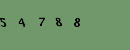

In [199]:
im2

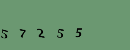

In [195]:
iz